# ASTR 496: Foundations of Data Science in Astronomy
# Fitting a Stellar Binary Orbit with MCMC using `emcee`
### Gautham Narayan

## Introduction

You are going to use Markov Chain Monte Carlo (MCMC) to fit the radial velocity curve of a binary star system. This is a fairly common problem in astrophysics where we observe the Doppler shift of spectral lines as stars orbit their common center of mass. You've already modeled a transit for an exoplanet light curve, so might as well model the other common method to find them.


I'll give you the physical setup - 

A binary star system with one visible component shows periodic radial velocity variations:

$$v_r(t) = K \sin\left(\frac{2\pi(t - t_0)}{P}\right) + v_0$$

where:
- $K$ = velocity semi-amplitude (km/s)
- $P$ = orbital period (days)
- $t_0$ = time of periastron passage (days)
- $v_0$ = systemic velocity (km/s)

In [1]:
# Import required packages
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from scipy import stats
# import whatever else you want here

# Set random seed for reproducibility
np.random.seed(42) # the answer to Life, the Universe, Everything

# Plotting style
# %matplotlib ipympl

### Next, I'll create synthetic observations of a binary star system with known parameters, then add observational noise.

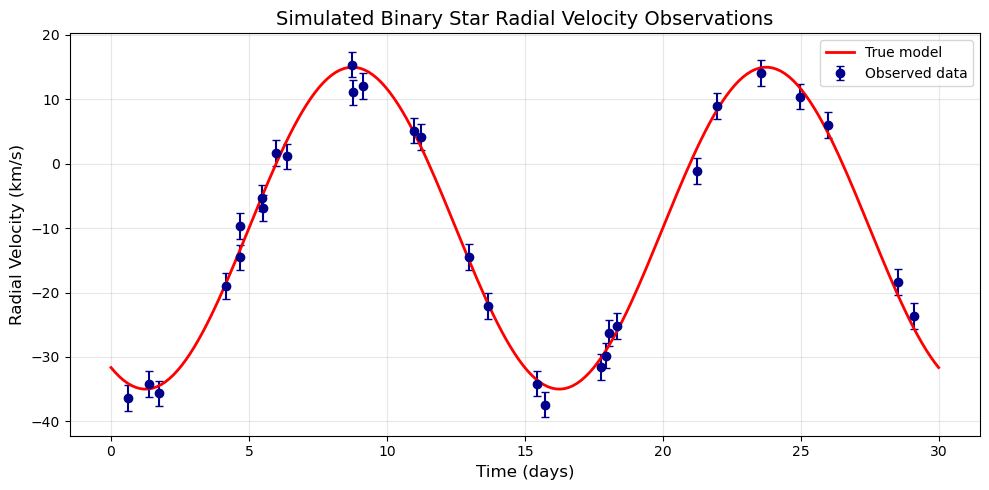

True parameters:
  K  = 25.0 km/s
  P  = 15.0 days
  t0 = 5.0 days
  v0 = -10.0 km/s


In [2]:
# True parameters (these are what we'll try to recover)
K_true = 25.0      # km/s
P_true = 15.0      # days
t0_true = 5.0      # days
v0_true = -10.0    # km/s

# Observation setup
n_obs = 30
t_obs = np.sort(np.random.uniform(0, 30, n_obs))  # Random times over 30 days
v_err = 2.0  # Measurement uncertainty (km/s)

# Model function
def radial_velocity_model(t, K, P, t0, v0):
    """Calculate radial velocity at time t for circular orbit"""
    phase = 2 * np.pi * (t - t0) / P
    return K * np.sin(phase) + v0

# Generate true signal
v_true = radial_velocity_model(t_obs, K_true, P_true, t0_true, v0_true)

# Add Gaussian noise
v_obs = v_true + np.random.normal(0, v_err, n_obs)

# Plot the data
plt.figure(figsize=(10, 5))
plt.errorbar(t_obs, v_obs, yerr=v_err, fmt='o', label='Observed data', 
             color='darkblue', markersize=6, capsize=3)
t_model = np.linspace(0, 30, 200)
v_model = radial_velocity_model(t_model, K_true, P_true, t0_true, v0_true)
plt.plot(t_model, v_model, 'r-', label='True model', linewidth=2)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Radial Velocity (km/s)', fontsize=12)
plt.title('Simulated Binary Star Radial Velocity Observations', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"True parameters:")
print(f"  K  = {K_true:.1f} km/s")
print(f"  P  = {P_true:.1f} days")
print(f"  t0 = {t0_true:.1f} days")
print(f"  v0 = {v0_true:.1f} km/s")

### OK now for the homework:

For MCMC, we need to define:
1. **Log-likelihood**: How well does a model fit the data?
2. **Log-prior**: What do we know before seeing the data?
3. **Log-posterior**: Combination of likelihood and prior (what we sample)

In [3]:
# Make model
def model(theta, t):
    K, P, t0, v0 = theta
    return K * np.sin(2*np.pi*(t - t0)/P) + v0

def log_likelihood(theta, t, v, v_err):
    """
    Calculate the log-likelihood of the model given the data.
    Remember
    theta : array
        Model parameters [K, P, t0, v0]
    t : array
        Observation times
    v : array
        Observed velocities
    v_err : float
        Measurement uncertainty
    """
    # you're doing this
    # using gaussian likelihood
    
    K, P, t0, v0 = theta
    
    v_model = model(theta, t)
    resid = v - v_model
    chisq = np.sum((resid/v_err)**2)
 
    logL = -0.5 * (chisq + np.sum(np.log(2*np.pi*v_err**2)))
    
    return logL
    

def log_prior(theta):
    """
    Returns -inf if parameters are outside allowed ranges.
    """
    # you're doing this
    K, P, t0, v0 = theta
    
    if 0 <= K <= 1e4 and 0 < P <= 1e4 and 0 < t0 <= 100 and -1000 <= v0 <= 1000:
        return 0.0  
    
    return -np.inf

def log_probability(theta, t, v, v_err):
    """
    Calculate the log-posterior probability.

    """
    # you're doing this 
    return log_prior(theta) + log_likelihood(theta, t, v, v_err)
    

#### Justify the choice of prior in a few sentences

Particularly for this example, we know that it's parameters resemble a standard binary star. Since we know the true value, I think two-order of magnitudes higher than the true value is justtifiable, i.e. $0 < K \leq 10^4$, $0  < P \leq 10^4$, $0 < t_0 \leq 100$, $-1000 \leq v_0 \leq 1000$

#### Describe how you treated the uncertainties in a few sentences

As I am using the Gaussian likelihood, I am treating the uncertainties as Gaussian standard deviations.

#### Next setup the MCMC. 

Use the affine-invariant ensemble sampler from `emcee`. This requires:
- Initial positions for multiple "walkers" (independent MCMC chains)
- Number of steps to run

**Rule of thumb**: Use at least 2×(number of parameters) walkers.

In [4]:
# MCMC setup
ndim = 4
nwalkers = 32
nsteps = 5000

# Set some initial positions for the walkers - I'd suggest adding small random scatter around a guess
# you can get your guess from scipy.optimize or just making something up.
from scipy.optimize import curve_fit

def model_2(t, K, P, t0, v0):
    return K * np.sin(2*np.pi*(t - t0)/P) + v0

popt, pcov = curve_fit(model_2, t_obs, v_obs, p0=[0.5*(v_obs.max()-v_obs.min()), 0.5*(t_obs.max()-t_obs.min()), t_obs[np.argmax(v_obs)], np.mean(v_obs)])
K_guess, P_guess, t0_guess, v0_guess = popt

starting_guess = np.array([K_guess, P_guess, t0_guess, v0_guess]) + np.random.normal(size=(nwalkers, ndim))
popt

array([ 24.65629694,  15.154631  ,   4.94647134, -10.56684375])

#### Run the MCMC Sampler
This may take a minute or two.

In [5]:
# Initialize the sampler

# Run MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(t_obs, v_obs, v_err))
sampler.run_mcmc(starting_guess, nsteps, progress=True)

# Print the acceptance fraction from the sampler
print("Mean acceptance fraction:", np.mean(sampler.acceptance_fraction))

100%|██████████| 5000/5000 [00:01<00:00, 2562.52it/s]

Mean acceptance fraction: 0.5945125


#### Analyze the Chains

i.e. heck if the chains have "converged" (reached the posterior distribution).
Do this by plotting the `nsteps` samples from all `nwalkers` chains 

**Key concepts:**

- **Autocorrelation time**: How many steps until samples are independent
- **Burn-in**: Initial steps where walkers move from initial positions to the posterior
- **Thinning**: take every n'th sample from the chains to reduce the autocorrelation


You can look at the slides for notes on this. Make some reasonable choices! Or if you don't have a good sense, you can use a burn-in that is twice the maximum autocorrelation time, and thinning of 1/2 the minimum autocorrelation time. This implies that there are multiple autocorrelation times, and you have to figure out how. 

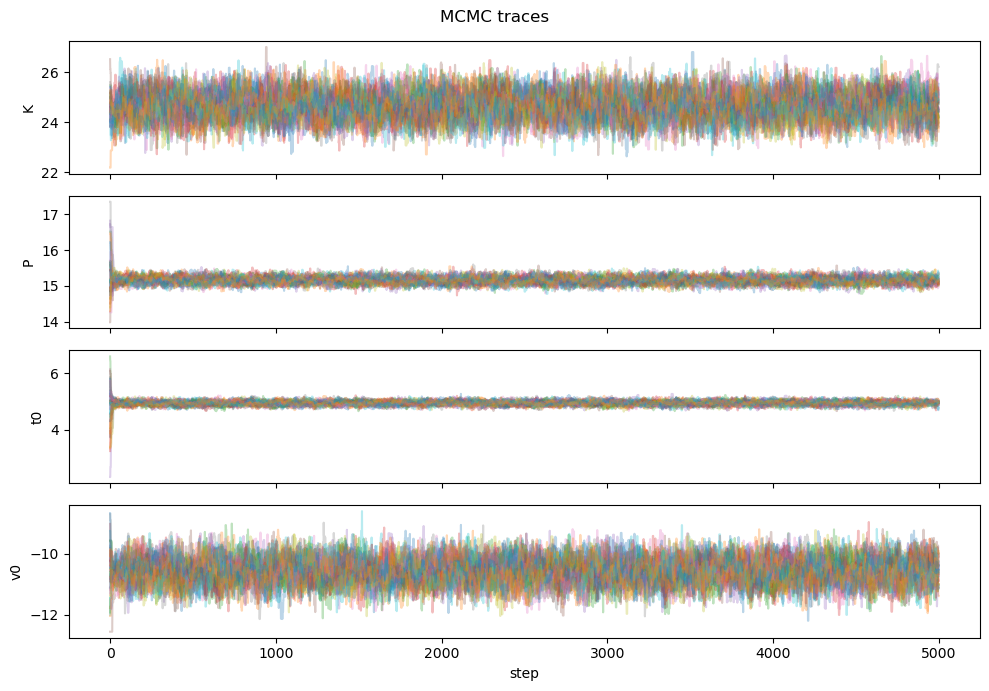

Autocorrelation times:
K: 43.7
P: 40.4
t0: 40.3
v0: 42.5
Burn-in = 87
thinning = 20


In [6]:
# Plot the chains - and remember to label your plots - you aren't silly first-years

labels = ["K", "P", "t0", "v0"]
chains = sampler.get_chain()   # shape (nsteps, nwalkers, ndim)

fig, axes = plt.subplots(ndim, 1, figsize=(10, 7), sharex=True)
for i in range(ndim):
    ax = axes[i]
    ax.plot(chains[:, :, i], alpha=0.3) 
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel("step")
fig.suptitle("MCMC traces")
plt.tight_layout()
plt.show()

# Calculate autocorrelation time

tau = sampler.get_autocorr_time()
print("Autocorrelation times:")
for name, t in zip(labels, tau):
    print(f"{name}: {t:.1f}")

burnin = int(2 * np.max(tau))   
thin   = int(0.5 * np.min(tau))

print(f"Burn-in = {burnin}\nthinning = {thin}")


#### Extract and Analyze Results

After discarding burn-in, you'll extract the posterior samples and calculate parameter estimates.

In [7]:
# Get flattened samples (discard burn-in and thin)
flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
print("Posterior shape:", flat_samples.shape)
    
# Calculate parameter estimates
med = np.median(flat_samples, axis=0)
lo  = np.percentile(flat_samples, 16, axis=0)
hi  = np.percentile(flat_samples, 84, axis=0)
lo_err = med - lo
hi_err = hi - med

for name, m, em, ep in zip(labels, med, lo_err, hi_err):
    print(f"{name} = {m:.3f} (+{ep:.3f}/-{em:.3f})")

Posterior shape: (7840, 4)
K = 24.662 (+0.509/-0.533)
P = 15.156 (+0.095/-0.094)
t0 = 4.944 (+0.074/-0.075)
v0 = -10.568 (+0.395/-0.393)


#### Create a Corner Plot

A corner plot shows all 1D and 2D marginalized distributions, revealing parameter correlations.

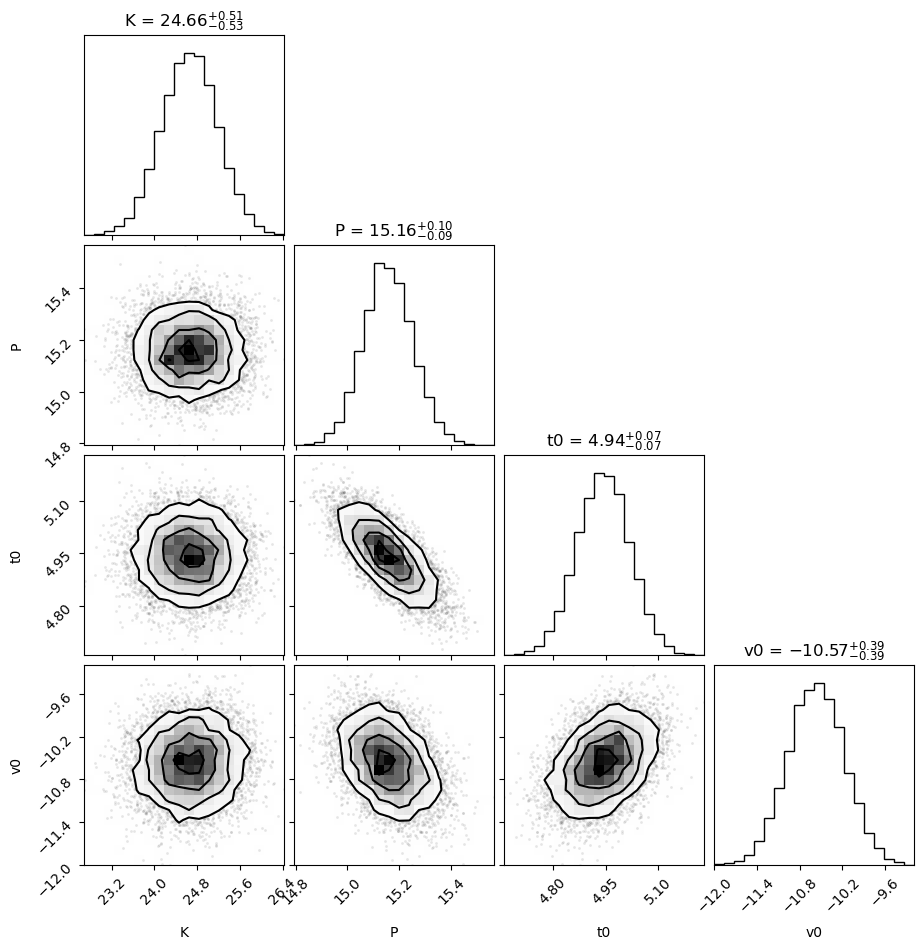

In [8]:
# you can use the corner package 
corner.corner(flat_samples, labels=labels, show_titles=True)
plt.show()

#### Plot the Best-Fit Model
LOOK AT YOUR DATA. Take the median estimate to be the "best-fit"
Plot some confidence interval

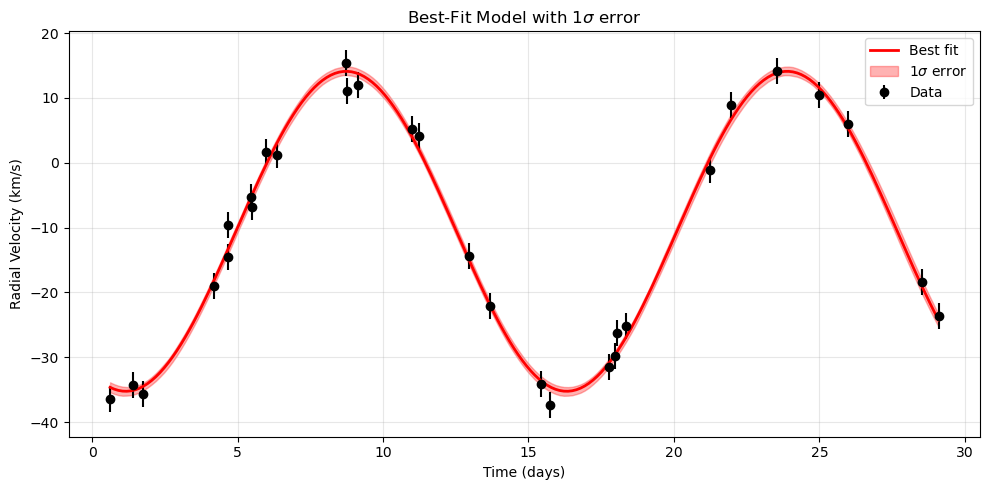

In [9]:
# also plot the true model - you can look at the simulation code
t_vals = np.linspace(min(t_obs), max(t_obs), 200)

# best-fit
theta_best = med
v_best = model(theta_best, t_vals)

# uncertainty 1-sigma
idx = np.random.randint(len(flat_samples), size=200)
v_samp = np.array([model(flat_samples[i], t_vals) for i in idx])

v_lo, v_hi = np.percentile(v_samp, [16, 84], axis=0)

plt.figure(figsize=(10, 5))
plt.errorbar(t_obs, v_obs, yerr=v_err, fmt='o', label='Data', color='black')
plt.plot(t_vals, v_best, 'r-', lw=2, label='Best fit') 
plt.fill_between(t_vals, v_lo, v_hi, color='r', alpha=0.3, label=r'1$\sigma$ error')    
plt.xlabel("Time (days)")
plt.ylabel("Radial Velocity (km/s)")
plt.title(r"Best-Fit Model with 1$\sigma$ error")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Finally, again a few sentences here:

**Correlations**: Examine the corner plot. Are any parameters correlated? Why might K and v₀ show correlation?

Based on the corner plot, there seems to be a correlation between $P$ vs $t_0$ and $P$ vs $v_0$. I do not think $K$ and $v_0$ show any correlation.

**Uncertainty**: Compare the posterior uncertainties to the true values. Did our MCMC analysis recover the true parameters within the error bars?

The table below compares posterior and true values.

| Value | Posterior | True |
|-------|-----------|------|
| $K$ | $24.662^{+0.509}_{-0.533}$ | $25$ | 
| $P$ | $15.156^{+0.095}_{-0.094}$ | $15$ |
| $t_0$ | $4.944^{+0.074}_{-0.075}$ | $5$ |
| $v_0$ | $-10.568^{+0.395}_{-0.393}$ | $-10$ |

Based on the posterior that we estimated, our MCMC analysis didn't recover all true parameters within the error bars, particularly for $P$ and $v_0$.

**Sensitivity**: What happens if you increase the measurement uncertainty (`v_err`)? Try changing it to 10.0 km/s and rerun.

When I changed $v_err = 10$, the uncertainties of the posterior/best-fit model increases.

![./best_fit_model_v_err_10.png](./best_fit_model_v_err_10.png)

**Sampling**: What would happen if you used too few walkers (e.g., nwalkers=4)? Too few steps?

For too few walkers, `nwalkers=4`, I get a `ValueError` of `ValueError: Initial state has a large condition number. Make sure that your walkers are linearly independent for the best performance. 

For too few steps, `nsteps=100`, I get a `AutocorrError` of `AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain! N/50 = 2;`.

I think if we have too few walkers / steps, the MCMC analysis would not explore more samples and the chain may get stuck in a "local minima"